## **Supply_Chain_Vulnerability_Analysis**
This notebook provides a comprehensive quantitative assessment of import supply chain risks using bilateral trade data from 2010 to 2024. By applying the Herfindahl-Hirschman Index (HHI), the analysis measures market concentration at both the commodity and partner-country levels to identify potential dependencies and vulnerabilities.



This cell initializes the Python environment by importing essential libraries for data manipulation (pandas, numpy), file management (os, warnings), and data visualization (matplotlib, seaborn). It also configures display settings for Pandas DataFrames to ensure large datasets are readable and suppresses non-critical warnings to keep the output clean.

In [33]:
# Cell 1: Imports and setup
import os
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display helpers (optional)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None

# Pandas display options
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 220)

# Plot styling
plt.rcParams["figure.figsize"] = (12, 5)
sns.set_theme(style="whitegrid")

# Suppress warnings
warnings.filterwarnings("ignore")

print(f"Environment ready — pandas {pd.__version__}, numpy {np.__version__}, seaborn {sns.__version__}")


Environment ready — pandas 2.2.2, numpy 2.0.2, seaborn 0.13.2


### **Load Master Dataset**
Here, the notebook loads the `master_dataset.csv`, which likely contains macroeconomic or sectoral indicators. It performs an initial inspection of the data dimensions and columns. Crucially, it attempts to parse date columns into a standardized datetime format to enable time-series analysis, handling various date formats or separate Year/Month columns automatically.

In [35]:
# Cell 2: Load your master dataset
master_path = "/content/master_dataset.csv"  # change path if needed
assert os.path.exists(master_path), f"master dataset not found at {master_path}"
master = pd.read_csv(master_path, low_memory=False)

print("master.shape:", master.shape)
print("master.columns:", list(master.columns)[:200])

# Try to detect/parse a date column
# prefer 'date' if it exists; otherwise try Year/Month combos
if "date" in master.columns:
    master["date_parsed"] = pd.to_datetime(master["date"], errors="coerce", infer_datetime_format=True)
else:
    # try Year + Month
    if "year" in master.columns and "month" in master.columns:
        master["date_parsed"] = pd.to_datetime(master["year"].astype(str) + "-" + master["month"].astype(str).str.zfill(2) + "-01", errors="coerce")
    else:
        # fallback: try to find any 'year'/'month' variant
        cand_year = [c for c in master.columns if c.lower() == "year"]
        cand_month = [c for c in master.columns if c.lower() == "month"]
        if cand_year and cand_month:
            master["date_parsed"] = pd.to_datetime(master[cand_year[0]].astype(str) + "-" + master[cand_month[0]].astype(str).str.zfill(2) + "-01", errors="coerce")
        else:
            master["date_parsed"] = pd.NaT

if master["date_parsed"].notna().sum() > 0:
    print("master date range:", master["date_parsed"].min().date(), "→", master["date_parsed"].max().date())
else:
    print("No parsable date column found in master dataset.")

# Quick preview
display(master.head()) if display_dataframe_to_user is None else display_dataframe_to_user("master_head", master.head())


master.shape: (3476, 93)
master.columns: ['sector_name', 'date', 'iip_index', 'iip_mom_growth', 'iip_yoy_growth', 'is_energy_intensive', 'io_sector_name', 'sector_id', 'backward_linkage', 'forward_linkage', 'is_key_sector', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank', '5', 'CRUDE_PETRO', 'WHEAT_US_HRW', 'RICE_05', 'COPPER', 'ALUMINUM', 'CRUDE_PETRO_logret', 'WHEAT_US_HRW_logret', 'RICE_05_logret', 'COPPER_logret', 'ALUMINUM_logret', 'CRUDE_PETRO_vol_3m', 'CRUDE_PETRO_vol_6m', 'CRUDE_PETRO_vol_12m', 'WHEAT_US_HRW_vol_3m', 'WHEAT_US_HRW_vol_6m', 'WHEAT_US_HRW_vol_12m', 'RICE_05_vol_3m', 'RICE_05_vol_6m', 'RICE_05_vol_12m', 'COPPER_vol_3m', 'COPPER_vol_6m', 'COPPER_vol_12m', 'ALUMINUM_vol_3m', 'ALUMINUM_vol_6m', 'ALUMINUM_vol_12m', 'CRUDE_PETRO_shock', 'WHEAT_US_HRW_shock', 'RICE_05_shock', 'COPPER_shock', 'ALUMINUM_shock', 'Year', 'Month', 'ONI', 'Month_num', 'ENSO_Phase', 'ONI_lag_1m', 'ONI_lag_3m', 'ONI_lag_6m', 'wpi_(a)__

,sector_name,date,iip_index,iip_mom_growth,iip_yoy_growth,is_energy_intensive,io_sector_name,sector_id,backward_linkage,forward_linkage,is_key_sector,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,5,CRUDE_PETRO,WHEAT_US_HRW,RICE_05,COPPER,ALUMINUM,CRUDE_PETRO_logret,WHEAT_US_HRW_logret,RICE_05_logret,COPPER_logret,ALUMINUM_logret,CRUDE_PETRO_vol_3m,CRUDE_PETRO_vol_6m,CRUDE_PETRO_vol_12m,WHEAT_US_HRW_vol_3m,WHEAT_US_HRW_vol_6m,WHEAT_US_HRW_vol_12m,RICE_05_vol_3m,RICE_05_vol_6m,RICE_05_vol_12m,COPPER_vol_3m,COPPER_vol_6m,COPPER_vol_12m,ALUMINUM_vol_3m,ALUMINUM_vol_6m,ALUMINUM_vol_12m,CRUDE_PETRO_shock,WHEAT_US_HRW_shock,RICE_05_shock,COPPER_shock,ALUMINUM_shock,Year,Month,ONI,Month_num,ENSO_Phase,ONI_lag_1m,ONI_lag_3m,ONI_lag_6m,wpi_(a)__food_articles,wpi_ii_fuel_and_power,wpi_iii___manufactured_products,gdp_constant,gdp_current,gdp_growth_yoy,ARG,AUS,BRA,CAN,CHN,DEU,EA20,EU27_2020,FRA,GBR,IDN,IND,ITA,KOR,SAU,TUR,USA,ZAF,g20_avg_cpi_growth,energy_trade_value,total_trade_value,oil_shock_x_pagerank,oil_shock_x_betweenness,CRUDE_PETRO_lag1,WHEAT_US_HRW_lag1,RICE_05_lag1,COPPER_lag1,ALUMINUM_lag1,iip_yoy_growth_lag1,year,month,quarter,date_parsed
0,Manufacture of beverages,2012-04-01,134.2,NaN,NaN,False,Beverages,45.0,6.735902,1.047036,False,0.3,0.00212,0.512674,0.080434,0.015732,633,113.665500,266.323922,547.75,8289.480000,2049.670000,-0.035601,-0.063832,-0.000456,-0.021635,-0.063553,0.048197,0.036931,0.043585,0.046484,0.036586,0.054928,0.014263,0.040527,0.043094,0.035629,0.031643,0.058625,0.046561,0.046538,0.036056,0,0,0,0,0,2012.0,AMJ,-0.3,4.0,Neutral,-0.4,-0.7,-1.0,6.2,6.3,3.5,2.205223e+06,2.313203e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2012,4,2,2012-04-01
1,Manufacture of beverages,2012-05-01,147.1,9.612519,NaN,False,Beverages,45.0,6.735902,1.047036,False,0.3,0.00212,0.512674,0.080434,0.015732,634,104.086034,264.358724,600.50,7955.642857,2007.630952,-0.088042,-0.007406,0.091944,-0.041106,-0.020723,0.066614,0.053685,0.045979,0.043505,0.035919,0.049914,0.048649,0.058719,0.048654,0.022344,0.039656,0.057612,0.028027,0.043486,0.035953,0,0,1,0,0,2012.0,MJJ,-0.1,5.0,Neutral,-0.3,-0.4,-0.9,6.7,6.7,4.2,2.205223e+06,2.313203e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,113.665500,266.323922,547.75,8289.480000,2049.670000,NaN,2012,5,2,2012-05-01
2,Manufacture of beverages,2012-06-01,130.5,-11.284840,NaN,False,Beverages,45.0,6.735902,1.047036,False,0.3,0.00212,0.512674,0.080434,0.015732,635,90.728254,276.189919,600.00,7423.023810,1890.178571,-0.137349,0.043782,-0.000833,-0.069295,-0.060284,0.050882,0.077419,0.060171,0.053828,0.037356,0.049639,0.053456,0.054457,0.046589,0.023962,0.050967,0.059555,0.023840,0.048468,0.037558,0,0,0,0,0,2012.0,JJA,0.1,6.0,Neutral,-0.1,-0.4,-0.5,9.3,5.5,4.4,2.205223e+06,2.313203e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,104.086034,264.358724,600.50,7955.642857,2007.630952,NaN,2012,6,2,2012-06-01
3,Manufacture of beverages,2012-07-01,93.1,-28.659004,NaN,False,Beverages,45.0,6.735902,1.047036,False,0.3,0.00212,0.512674,0.080434,0.015732,636,96.754113,345.687947,573.75,7584.261364,1876.250000,0.064304,0.224448,-0.044736,0.021489,-0.007396,0.105123,0.083516,0.063654,0.121804,0.098237,0.081632,0.069781,0.045518,0.048028,0.046466,0.042973,0.055663,0.027507,0.035105,0.037750,0,1,0,0,0,2012.0,JAS,0.3,7.0,Neutral,0.1,-0.3,-0.7,11.3,3.5,4.9,2.205223e+06,2.313203e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,90.728254,276.189919,600.00,7423.023810,1890.178571,NaN,2012,7,3,2012-07-01
4,Manufacture of beverages,2012-08-01,85.1,-8.592911,NaN,False,Beverages,45.0,6.735902,1.047036,False,0.3,0.00212,0.512674,0.080434,0.015732,637,105.273637,349.400351,567.75,7515.532609,1845.376087,0.084390,0.010682,-0.010513,-0.009103,-0.016592,0.122

### **Load Bilateral Trade Data**
This cell ingests the specific trade data file (`trade_india_bilateral.csv`). This dataset serves as the granular source for import/export flows between India and its partner countries, which is the foundation for calculating trade concentration indices later in the notebook.

In [36]:
# Cell 3: Load trade_india_bilateral.csv
trade_path = "/content/trade_india_bilateral.csv"
assert os.path.exists(trade_path), f"trade file not found at {trade_path}"
trade = pd.read_csv(trade_path, low_memory=False)

print("trade.shape:", trade.shape)
print("trade.columns:", list(trade.columns))

# Show sample rows
display(trade.head()) if display_dataframe_to_user is None else display_dataframe_to_user("trade_head", trade.head())


trade.shape: (9720, 6)
trade.columns: ['COUNTRY', 'COUNTERPART_COUNTRY', 'TRADE_FLOW', 'commodity_group', 'date', 'trade_value_usd']


,COUNTRY,COUNTERPART_COUNTRY,TRADE_FLOW,commodity_group,date,trade_value_usd
0,India,Qatar,Trade balance goods,Other,2010-M01,NaN
1,India,Qatar,Exports of goods,Other,2010-M01,22.638913
2,India,Saudi Arabia,Exports of goods,Other,2010-M01,263.895495
3,India,Saudi Arabia,Trade balance goods,Other,2010-M01,NaN
4,India,Saudi Arabia,Trade balance goods,Other,2010-M01,-1640.462379


### **Structural Exploration and Data Type Conversion**
Before analysis can begin, this cell inspects the structure of the trade data. It checks for unique values in key columns (Country, Partner, Flow) to understand the data's scope. Significantly, it cleans the `trade_value_usd` column—removing formatting characters like commas—and converts it into a numeric format (`trade_value_usd_num`) to allow for mathematical aggregation.

In [37]:
# Cell 4: Quick structural exploration
print("Unique values in COUNTRY:", trade["COUNTRY"].unique()[:10])
print("Unique COUNTERPART_COUNTRY count:", trade["COUNTERPART_COUNTRY"].nunique(), "examples:", trade["COUNTERPART_COUNTRY"].unique()[:10])
print("TRADE_FLOW values:", trade["TRADE_FLOW"].unique())
print("commodity_group unique values (count):", trade["commodity_group"].nunique())
print("date column sample:", trade["date"].head())

# Coerce trade_value_usd to numeric (create a clean numeric column)
if "trade_value_usd" in trade.columns:
    trade["trade_value_usd_num"] = pd.to_numeric(trade["trade_value_usd"].astype(str).str.replace(",","").str.strip(), errors="coerce")
    print("Non-missing trade_value_usd_num:", trade["trade_value_usd_num"].notna().sum(), "/", len(trade))
else:
    trade["trade_value_usd_num"] = np.nan
    print("No trade_value_usd column found; created blank numeric column.")

# Parse date column (try 'date' first)
if "date" in trade.columns:
    trade["date_parsed"] = pd.to_datetime(trade["date"], errors="coerce", infer_datetime_format=True)
else:
    # try Year/Month
    if "year" in trade.columns and "month" in trade.columns:
        trade["date_parsed"] = pd.to_datetime(trade["year"].astype(str) + "-" + trade["month"].astype(str).str.zfill(2) + "-01", errors="coerce")
    else:
        trade["date_parsed"] = pd.NaT

print("Parsed trade date range:", trade["date_parsed"].min(), "→", trade["date_parsed"].max())


Unique values in COUNTRY: ['India']
Unique COUNTERPART_COUNTRY count: 6 examples: ['Qatar' 'Saudi Arabia' 'United States' 'Italy' 'France' 'Germany']
TRADE_FLOW values: ['Trade balance goods' 'Exports of goods' 'Imports of goods']
commodity_group unique values (count): 1
date column sample: 0    2010-M01
1    2010-M01
2    2010-M01
3    2010-M01
4    2010-M01
Name: date, dtype: object
Non-missing trade_value_usd_num: 3240 / 9720
Parsed trade date range: 2010-01-01 00:00:01 → 2024-01-01 00:00:12


### **Data Filtering and Scope Definition**
This cell refines the dataset for the specific study of **Import Concentration**. It filters the data to retain only "Import" records, removes rows with missing values or partner names, and restricts the timeframe to the period between 2010 and 2024. This ensures the resulting analysis focuses strictly on supply-side risks over a relevant historical period.

In [39]:
# Cell 5: Filter and clean trade data
# Defaults chosen:
# - focus on Imports of goods
# - drop rows with missing trade_value_usd_num
# - filter to period 2010-01-01 through 2024-12-31 (inclusive)

# 1) Keep only India's imports
imports = trade[trade["TRADE_FLOW"].str.contains("Import", case=False, na=False)].copy()
print("Rows after filtering to import flows:", imports.shape)

# 2) Drop rows with missing partner or missing value
imports = imports[imports["COUNTERPART_COUNTRY"].notna()].copy()
before_drop = imports.shape[0]
imports = imports[imports["trade_value_usd_num"].notna()].copy()
after_drop = imports.shape[0]
print(f"Dropped {before_drop - after_drop} rows due to missing trade value. Remaining: {after_drop}")

# 3) Date filtering
start = pd.to_datetime("2010-01-01")
end = pd.to_datetime("2024-12-31")
imports = imports[(imports["date_parsed"] >= start) & (imports["date_parsed"] <= end)].copy()
print("Rows after date filtering (2010-2024):", imports.shape)

# 4) Quick cleaned summary
print("Unique partners remaining:", imports["COUNTERPART_COUNTRY"].nunique())
print("Unique commodity groups remaining:", imports["commodity_group"].nunique())


Rows after filtering to import flows: (3240, 8)
Dropped 2160 rows due to missing trade value. Remaining: 1080
Rows after date filtering (2010-2024): (1080, 8)
Unique partners remaining: 6
Unique commodity groups remaining: 1


### **Temporal Aggregation (Monthly and Annual)**
To facilitate trend analysis, this cell aggregates the raw transactional data into time buckets. It creates two new DataFrames: `monthly_agg` for high-resolution time series analysis, and `annual_agg` for broader yearly trends. The data is grouped by date, commodity type, and partner country, summing the trade values in USD.

In [40]:
# Cell 7: Group by date, commodity_group, partner (COUNTERPART_COUNTRY)
# We'll compute both monthly and annual aggregates; the default analysis will use annual.

# monthly aggregation (date_parsed to period month)
imports["month"] = imports["date_parsed"].dt.to_period("M").dt.to_timestamp()
monthly_agg = (imports
               .groupby(["month", "commodity_group", "COUNTERPART_COUNTRY"], dropna=False, as_index=False)
               ["trade_value_usd_num"]
               .sum()
               .rename(columns={"trade_value_usd_num": "imports_usd"}))

print("monthly_agg.shape:", monthly_agg.shape)
display(monthly_agg.head())

# annual aggregation
imports["year"] = imports["date_parsed"].dt.year
annual_agg = (imports
              .groupby(["year", "commodity_group", "COUNTERPART_COUNTRY"], dropna=False, as_index=False)
              ["trade_value_usd_num"]
              .sum()
              .rename(columns={"trade_value_usd_num": "imports_usd"}))

print("annual_agg.shape:", annual_agg.shape)
display(annual_agg.head())


monthly_agg.shape: (90, 4)


,month,commodity_group,COUNTERPART_COUNTRY,imports_usd
0,2010-01-01,Other,France,3827.730006
1,2010-01-01,Other,Germany,11471.567394
2,2010-01-01,Other,Italy,4310.881699
3,2010-01-01,Other,Qatar,6155.797943
4,2010-01-01,Other,Saudi Arabia,20406.524042


annual_agg.shape: (90, 4)


,year,commodity_group,COUNTERPART_COUNTRY,imports_usd
0,2010,Other,France,3827.730006
1,2010,Other,Germany,11471.567394
2,2010,Other,Italy,4310.881699
3,2010,Other,Qatar,6155.797943
4,2010,Other,Saudi Arabia,20406.524042


### **Calculation of Trade Shares**
This cell calculates the market share ($s_i$) of each partner country for every commodity in every year. By merging the annual totals back into the main dataset, it computes the percentage of total imports for a specific commodity that comes from specific partners. These fractional shares (0 to 1) are the prerequisite input for the Herfindahl-Hirschman Index (HHI) calculation.

In [41]:
# Cell 8: Calculate trade shares (we'll do this for annual_agg by default)
# For each (year, commodity_group) compute each partner's share of imports

agg = annual_agg.copy()

# total by year & commodity
total_by_group = agg.groupby(["year", "commodity_group"], as_index=False)["imports_usd"].sum().rename(columns={"imports_usd": "total_imports_usd"})
agg = agg.merge(total_by_group, on=["year", "commodity_group"], how="left")

# trade_share as decimal 0-1
agg["trade_share"] = agg["imports_usd"] / agg["total_imports_usd"]

# Verify shares sum ~1 for each year-commodity
check = agg.groupby(["year", "commodity_group"], as_index=False)["trade_share"].sum().rename(columns={"trade_share": "sum_shares"})
print("Share sum diagnostics (sample):")
display(check.head())

# If commodity_group lacks detail (e.g., single 'Other'), the share will be 1 for the single group across partners aggregated.


Share sum diagnostics (sample):


,year,commodity_group,sum_shares
0,2010,Other,1.0
1,2011,Other,1.0
2,2012,Other,1.0
3,2013,Other,1.0
4,2014,Other,1.0


### **HHI Function Definition**
Here, the Herfindahl-Hirschman Index (HHI) logic is defined as a Python function. The HHI is a standard economic measure of market concentration calculated by squaring the market share of each firm (or in this case, partner country) and summing the results. The output ranges from close to 0 (perfectly competitive/diversified) to 10,000 (monopoly).

In [42]:
# Cell 9: HHI function definitions
def hhi_from_shares_decimal(shares):
    """
    shares: iterable of shares expressed as decimals summing to ~1 (e.g., 0.5, 0.3, 0.2)
    returns: HHI on 0-10,000 scale
    """
    arr = np.array(shares, dtype=float)
    # protect against NaNs
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    return float(np.sum((arr ** 2)) * 10000.0)

# quick tests
print("HHI test (two partners 50/50) => should be 5000:", hhi_from_shares_decimal([0.5, 0.5]))
print("HHI test (single partner 100%) => should be 10000:", hhi_from_shares_decimal([1.0]))


HHI test (two partners 50/50) => should be 5000: 5000.0
HHI test (single partner 100%) => should be 10000: 10000.0


### **Compute HHI by Commodity**
This cell applies the HHI function defined previously to the aggregated trade data. It groups the data by Year and Commodity to produce a concentration score (`hhi`) for every commodity group annually. This metric quantifies the diversity of the supply chain for each good.

In [43]:
# Cell 10: HHI by (year, commodity_group)
# Group and apply HHI to trade_share for each year-commodity_group
def compute_hhi_group(df, group_cols=["year", "commodity_group"], share_col="trade_share"):
    g = (df.groupby(group_cols, as_index=False)
         .agg(hhi=(share_col, lambda s: hhi_from_shares_decimal(s.values))))
    return g

hhi_by_commodity = compute_hhi_group(agg, group_cols=["year", "commodity_group"], share_col="trade_share")
print("hhi_by_commodity sample:")
display(hhi_by_commodity.head())

# If commodity_group has only 'Other', these HHIs are the HHI of partner concentration across all imports in that year.


hhi_by_commodity sample:


,year,commodity_group,hhi
0,2010,Other,2310.174450
1,2011,Other,2284.513500
2,2012,Other,2309.226130
3,2013,Other,2488.023934
4,2014,Other,2386.568572


### **Visualizing Concentration Trends**
Using `matplotlib`, this cell generates a line plot tracking the HHI over time for selected commodities. It includes reference lines at HHI=1500 and HHI=2500, which are standard thresholds used (e.g., by the DOJ) to classify markets as "Moderately Concentrated" or "Highly Concentrated," allowing for immediate visual risk assessment.

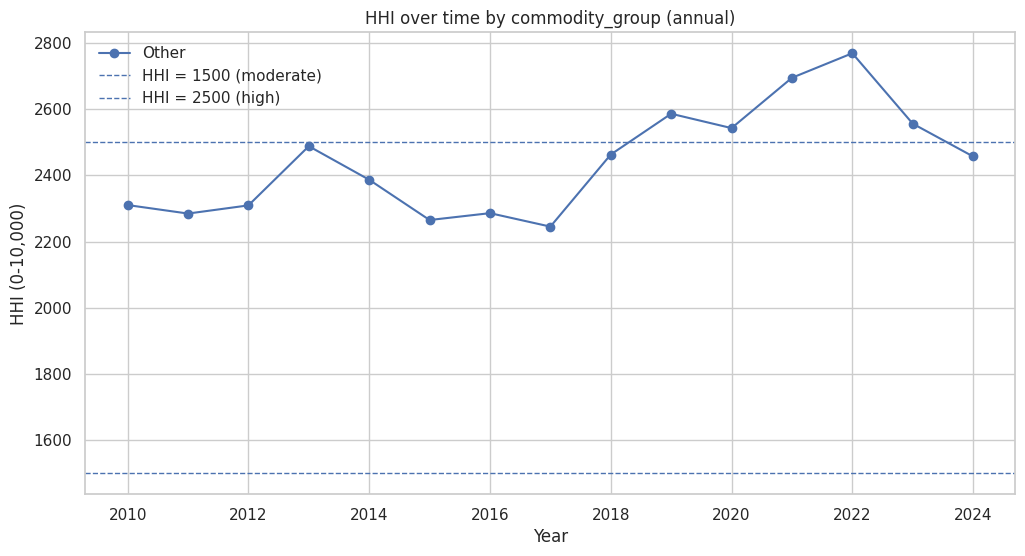

In [44]:
# Cell 11: Visualize HHI over time for selected commodity groups
# Choose up to 5 commodity groups that exist in data. If only 'Other', plot that.
unique_comm = hhi_by_commodity["commodity_group"].unique().tolist()
selected = unique_comm[:5]  # top 5 or the only available ones

plt.figure(figsize=(12, 6))
for comm in selected:
    sub = hhi_by_commodity[hhi_by_commodity["commodity_group"] == comm].sort_values("year")
    plt.plot(sub["year"], sub["hhi"], marker="o", label=str(comm))
# reference lines
plt.axhline(1500, linestyle="--", linewidth=1, label="HHI = 1500 (moderate)")
plt.axhline(2500, linestyle="--", linewidth=1, label="HHI = 2500 (high)")

plt.title("HHI over time by commodity_group (annual)")
plt.xlabel("Year")
plt.ylabel("HHI (0-10,000)")
plt.legend()
plt.grid(True)
plt.show()


### **Ranking Commodities by Risk**
This cell performs a statistical aggregation to rank commodities based on their average HHI over the analyzed period. It sorts them in descending order to identify which goods have historically had the most concentrated (and therefore riskiest) supply chains. A bar chart is generated to visualize the top 20 most concentrated commodities.

,commodity_group,avg_hhi,median_hhi,max_hhi,obs
0,Other,2442.817305,2456.970302,2768.794439,15


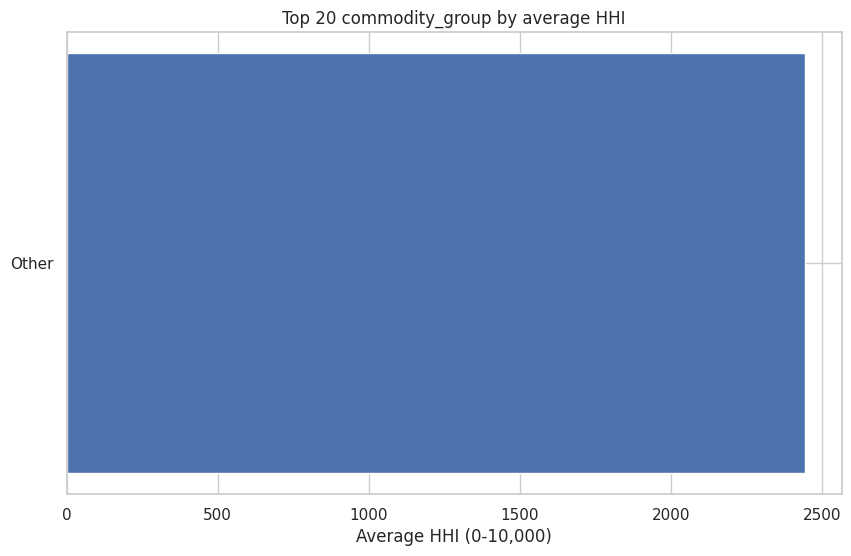

In [45]:
# Cell 12: Average HHI by commodity (descending)
avg_hhi = (hhi_by_commodity
           .groupby("commodity_group", as_index=False)
           .agg(avg_hhi=("hhi", "mean"),
                median_hhi=("hhi", "median"),
                max_hhi=("hhi", "max"),
                obs=("hhi", "count"))
           .sort_values("avg_hhi", ascending=False))

display(avg_hhi.head(20))

# Bar chart of top 20 (if many exist)
top20 = avg_hhi.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20["commodity_group"].astype(str)[::-1], top20["avg_hhi"][::-1])
plt.xlabel("Average HHI (0-10,000)")
plt.title("Top 20 commodity_group by average HHI")
plt.show()


### **Partner-Centric Concentration Analysis**
This step effectively "flips" the analysis. Instead of looking at how concentrated a commodity is, it looks at how concentrated India's trade relationship is with specific partners. It calculates an HHI score for each Partner Country based on the mix of commodities imported from them, indicating if a trading relationship is dominated by a single product type.

In [46]:
# Cell 13: Flip analysis — for each partner country, compute HHI across commodities (how diversified their exports to India are)
# We'll compute annual HHI per partner across commodity_group shares of that partner's exports to India.
# First compute partner-centric shares: for each year & partner, what share does each commodity have of that partner's exports to India

partner_comm = (imports
                .groupby(["year", "COUNTERPART_COUNTRY", "commodity_group"], as_index=False)["trade_value_usd_num"]
                .sum()
                .rename(columns={"trade_value_usd_num": "value_usd"}))

# total exports from each partner to India by year (sum over commodities)
tot_partner = partner_comm.groupby(["year", "COUNTERPART_COUNTRY"], as_index=False)["value_usd"].sum().rename(columns={"value_usd":"partner_total_usd"})
partner_comm = partner_comm.merge(tot_partner, on=["year", "COUNTERPART_COUNTRY"], how="left")
partner_comm["share_of_partner"] = partner_comm["value_usd"] / partner_comm["partner_total_usd"]

# HHI per partner-year across commodities
hhi_by_partner = (partner_comm
                  .groupby(["year", "COUNTERPART_COUNTRY"], as_index=False)
                  .agg(hhi_partner=("share_of_partner", lambda s: hhi_from_shares_decimal(s.values)),
                       total_from_partner=("partner_total_usd", "first")))

display(hhi_by_partner.sort_values(["year", "hhi_partner"], ascending=[True, False]).head(20))


,year,COUNTERPART_COUNTRY,hhi_partner,total_from_partner
0,2010,France,10000.0,3827.730006
1,2010,Germany,10000.0,11471.567394
2,2010,Italy,10000.0,4310.881699
3,2010,Qatar,10000.0,6155.797943
4,2010,Saudi Arabia,10000.0,20406.524042
5,2010,United States,10000.0,19135.633740
6,2011,France,10000.0,4152.084337
7,2011,Germany,10000.0,15274.869920
8,2011,Italy,10000.0,5220.196178
9,2011,Qatar,10000.0,11282.844099


### **Identifying Top Trading Partners**
This cell aggregates total trade volume by partner country across the entire time period to identify the largest suppliers by value. It merges this volume data with the partner-level HHI calculated in the previous step to provide a summary of both the *scale* and the *diversity* of trade with key partners like the USA, Saudi Arabia, and China.

,COUNTERPART_COUNTRY,total_imports_usd
5,United States,452962.708391
4,Saudi Arabia,423029.416630
1,Germany,200302.397233
3,Qatar,172515.238930
2,Italy,71436.124557
0,France,65904.045546


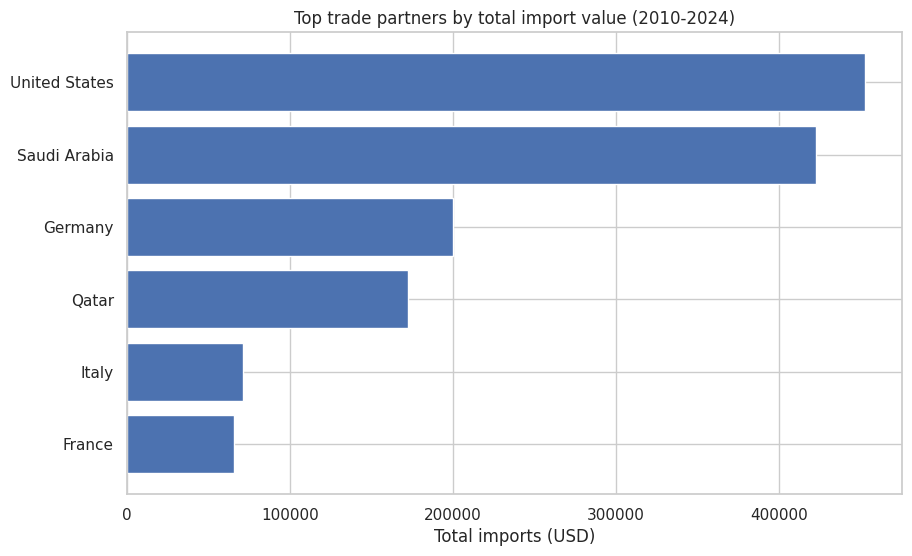

,COUNTERPART_COUNTRY,total_imports_usd,avg_hhi_partner
0,United States,452962.708391,10000.0
1,Saudi Arabia,423029.416630,10000.0
2,Germany,200302.397233,10000.0
3,Qatar,172515.238930,10000.0
4,Italy,71436.124557,10000.0
5,France,65904.045546,10000.0


In [47]:
# Cell 14: Top partners by total volume (2010-2024)
total_from_each_partner = imports.groupby("COUNTERPART_COUNTRY", as_index=False)["trade_value_usd_num"].sum().rename(columns={"trade_value_usd_num":"total_imports_usd"})
total_from_each_partner = total_from_each_partner.sort_values("total_imports_usd", ascending=False)

display(total_from_each_partner.head(20))

# bar chart of top 20 partners
top20p = total_from_each_partner.head(20)
plt.figure(figsize=(10,6))
plt.barh(top20p["COUNTERPART_COUNTRY"][::-1], top20p["total_imports_usd"][::-1])
plt.title("Top trade partners by total import value (2010-2024)")
plt.xlabel("Total imports (USD)")
plt.show()

# Merge average HHI (partner-level) to this summary (use mean across years)
avg_partner_hhi = hhi_by_partner.groupby("COUNTERPART_COUNTRY", as_index=False)["hhi_partner"].mean().rename(columns={"hhi_partner":"avg_hhi_partner"})
partner_summary = total_from_each_partner.merge(avg_partner_hhi, on="COUNTERPART_COUNTRY", how="left")
display(partner_summary.head(20))


### **Regional Supply Chain Analysis**
To assess geopolitical risk, this cell maps individual countries to broader regions (e.g., Middle East, Europe). It aggregates import volumes by region and year, then visualizes the changing reliance on these geopolitical blocks using a stacked area chart.

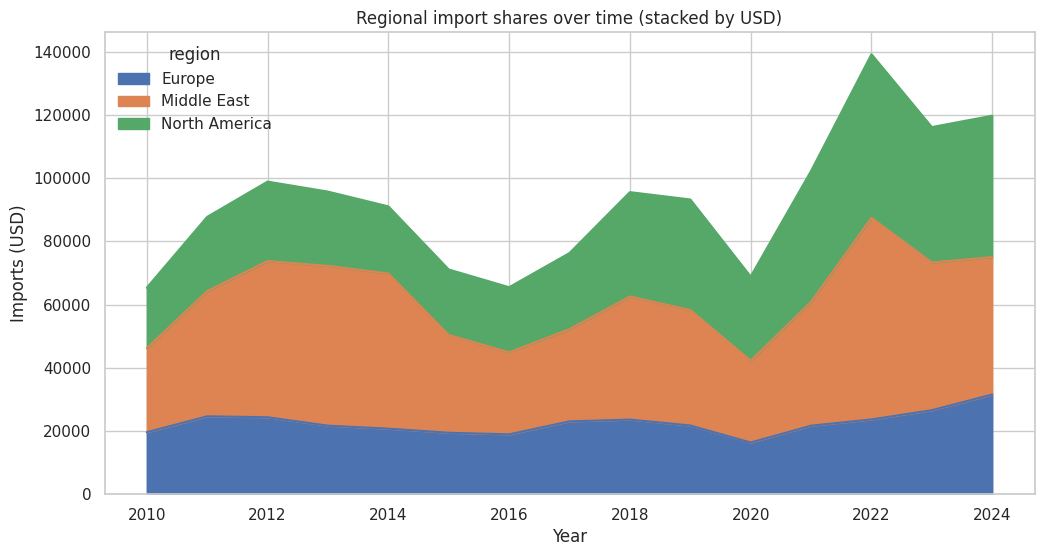

In [48]:
# Cell 15: Map countries to regions (simple mapping; replace with your preferred classification)
# Quick manual mapping for partners found; for larger lists use a country->WB region lookup table.
country_to_region = {
    "Qatar": "Middle East",
    "Saudi Arabia": "Middle East",
    "United States": "North America",
    "Italy": "Europe",
    "France": "Europe",
    "Germany": "Europe"
}
# apply mapping
imports["region"] = imports["COUNTERPART_COUNTRY"].map(country_to_region).fillna("Other")

# compute regional share by year
region_year = (imports
               .groupby(["year", "region"], as_index=False)["trade_value_usd_num"]
               .sum()
               .rename(columns={"trade_value_usd_num":"imports_usd"}))

# pivot for stacked area plot
pivot = region_year.pivot(index="year", columns="region", values="imports_usd").fillna(0)

pivot.plot(kind="area", stacked=True, figsize=(12,6))
plt.title("Regional import shares over time (stacked by USD)")
plt.ylabel("Imports (USD)")
plt.xlabel("Year")
plt.show()


### **Mapping Commodities to Economic Sectors**
This cell bridges the gap between trade data (Commodities) and broader economic models (Input-Output Sectors). It applies a dictionary mapping to classify specific commodities into broader industrial sectors (e.g., mapping "Iron Ore" to the "Iron and Steel" sector), preparing the data for sector-level vulnerability analysis.

In [49]:
# Cell 16: Map commodities to IO sectors
# NOTE: commodity_group in this dataset may be 'Other' — below is a placeholder mapping dict.
# Replace keys with real commodity identifiers if available (e.g., HS codes -> IO sectors).

commodity_to_sector = {
    "Crude petroleum": "Petroleum products",
    "Iron ore": "Iron and steel",
    "Natural gas": "Electricity/gas supply",
    # Add mappings as you have them...
    "Other": "Unmapped"
}

# apply mapping to annual_agg and hhi_by_commodity
agg["io_sector"] = agg["commodity_group"].map(commodity_to_sector).fillna("Unmapped")
hhi_by_commodity = hhi_by_commodity.merge(agg[["year", "commodity_group", "io_sector"]].drop_duplicates(), on=["year", "commodity_group"], how="left")


### **Aggregating Risk to Sector Level**
Here, the notebook calculates a **Weighted Average HHI** for each Input-Output (IO) Sector. Since a sector relies on multiple commodities, this step weighs the HHI of each commodity by its import value to derive a single concentration score for the entire industrial sector.

In [50]:
# Cell 17: Aggregate HHI to I-O sector level
# Weighted average HHI by import value for a sector in a given year
sector_vals = (agg
               .groupby(["year", "io_sector"], as_index=False)
               .apply(lambda df: pd.Series({
                   "sector_total_imports": df["total_imports_usd"].sum(),
                   # weighted HHI: sum(hhi_of_commodity * commodity_total_imports)/sector_total_imports
                   "weighted_avg_hhi": (hhi_by_commodity[hhi_by_commodity["commodity_group"].isin(df["commodity_group"])]
                                       .groupby("commodity_group", as_index=False)["hhi"].first()
                                       .assign(commodity_total=df.groupby("commodity_group")["total_imports_usd"].first().values)
                                       .pipe(lambda d: (d["hhi"] * d["commodity_total"]).sum() / d["commodity_total"].sum() if d["commodity_total"].sum() > 0 else np.nan)
                                      )
               }))
               .reset_index())

# Fallback simpler approach if above mapping doesn't return values:
if sector_vals["weighted_avg_hhi"].isna().all():
    # compute simple average of commodity HHIs per sector-year
    merge_tmp = hhi_by_commodity.merge(agg[["year","commodity_group","io_sector"]].drop_duplicates(), on=["year","commodity_group"], how="left")
    sector_vals = merge_tmp.groupby(["year","io_sector"], as_index=False).agg(
        weighted_avg_hhi=("hhi","mean"),
        sector_total_imports=("commodity_group", "count")
    )

display(sector_vals.head(20))


,index,year,io_sector,sector_total_imports,weighted_avg_hhi
0,0,2010,Unmapped,391848.808944,2310.17445
1,1,2011,Unmapped,526231.006812,2310.17445
2,2,2012,Unmapped,593172.236058,2310.17445
3,3,2013,Unmapped,574206.304344,2310.17445
4,4,2014,Unmapped,546183.982602,2310.17445
5,5,2015,Unmapped,426440.267142,2310.17445
6,6,2016,Unmapped,392770.548414,2310.17445
7,7,2017,Unmapped,457618.560000,2310.17445
8,8,2018,Unmapped,573203.940000,2310.17445
9,9,2019,Unmapped,559275.540000,2310.17445


### **Integrating Network Metrics**
This cell loads external network topology data (`network_metrics.csv`), which likely contains centrality scores (like PageRank) for economic sectors. It merges this data with the Sector HHI data. This combination allows for an analysis of "Systemic Vulnerability"—identifying sectors that are both highly concentrated in imports (High HHI) and central to the domestic economy (High Network Centrality).

In [51]:
# Cell 18: Load network_metrics.csv and merge with sector_trade_concentration
network_path = "/content/network_metrics.csv"
if os.path.exists(network_path):
    net = pd.read_csv(network_path, low_memory=False)
    print("network_metrics loaded:", net.shape)
    # assume net has a sector identifier column like 'io_sector' or 'sector_name'
    if "io_sector" in net.columns:
        merged = sector_vals.merge(net, on="io_sector", how="left")
    elif "sector_name" in net.columns:
        merged = sector_vals.merge(net, left_on="io_sector", right_on="sector_name", how="left")
    else:
        # try fuzzy match or leave unmerged
        merged = sector_vals.copy()
        print("Could not find matching sector column in network metrics; merged left as-is.")
else:
    print(f"network_metrics.csv not found at {network_path}. Skipping merge.")
    merged = sector_vals.copy()

display(merged.head())


network_metrics loaded: (131, 10)


,index,year,io_sector,sector_total_imports,weighted_avg_hhi,sector_id,sector_name,backward_linkage,forward_linkage,is_key_sector,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,0,2010,Unmapped,391848.808944,2310.17445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2011,Unmapped,526231.006812,2310.17445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012,Unmapped,593172.236058,2310.17445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013,Unmapped,574206.304344,2310.17445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2014,Unmapped,546183.982602,2310.17445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Vulnerability Matrix Visualization**
This cell generates a scatter plot representing a **Vulnerability Matrix**.
* **X-Axis:** Trade Concentration (HHI) - Supply Risk.
* **Y-Axis:** Network Centrality - Systemic Importance.
Sectors appearing in the top-right quadrant are critical vulnerabilities: they are central to the economy yet rely on highly concentrated supply chains.

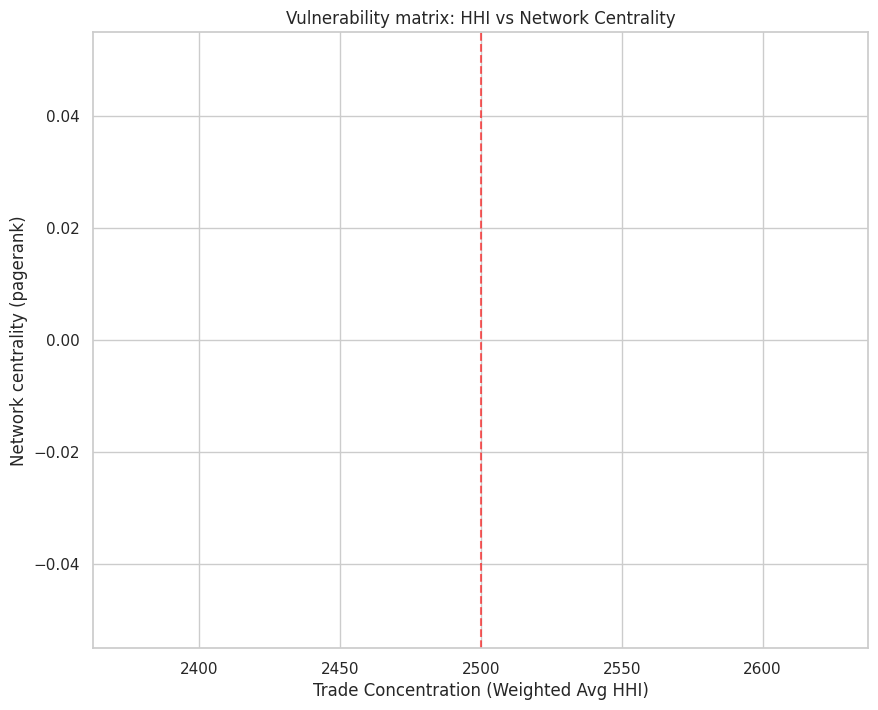

In [52]:
# Cell 19: Vulnerability matrix scatter plot
# X-axis: HHI (trade concentration), Y-axis: network centrality (use PageRank if available)
plot_df = merged.copy()

# determine a centrality column to use
centrality_col = None
for c in ["pagerank", "page_rank", "PageRank", "centrality", "betweenness"]:
    if c in plot_df.columns:
        centrality_col = c
        break

if centrality_col is None:
    # create a dummy centrality if absent (use random or backward linkage if present)
    if "backward_linkage" in plot_df.columns:
        centrality_col = "backward_linkage"
    else:
        plot_df["centrality_dummy"] = np.random.rand(len(plot_df))
        centrality_col = "centrality_dummy"

# size of points: use sector_total_imports if present
size_col = "sector_total_imports" if "sector_total_imports" in plot_df.columns else None
sizes = (plot_df[size_col].fillna(0) / (plot_df[size_col].max() if size_col and plot_df[size_col].max() > 0 else 1)) * 300 if size_col else 100

plt.figure(figsize=(10,8))
plt.scatter(plot_df["weighted_avg_hhi"], plot_df[centrality_col], s=sizes, alpha=0.7)
for _, row in plot_df.iterrows():
    plt.text(row["weighted_avg_hhi"], row[centrality_col], str(row.get("io_sector","")), fontsize=8, alpha=0.9)

plt.xlabel("Trade Concentration (Weighted Avg HHI)")
plt.ylabel(f"Network centrality ({centrality_col})")
plt.title("Vulnerability matrix: HHI vs Network Centrality")
plt.axvline(2500, linestyle="--", color="red", alpha=0.6)
plt.show()


### **Identification of Dominant Suppliers**
For every sector and year, this cell identifies the "Top Partner"—the country providing the largest share of imports. It creates a flag (`flag_major_dependency`) to highlight instances where a single country controls more than 50% of the supply for a specific sector, indicating a critical dependency.

In [53]:
# Cell 20: For each sector, find dominant import partner (% from top partner)
# We'll compute this using imports aggregated by io_sector (or commodity_group if unmapped)

# pick the aggregation level available: io_sector if exists, else commodity_group
if "io_sector" in imports.columns and imports["io_sector"].notna().any():
    level_col = "io_sector"
else:
    level_col = "commodity_group"

by_sector_partner = (imports
                     .groupby(["year", level_col, "COUNTERPART_COUNTRY"], as_index=False)["trade_value_usd_num"]
                     .sum()
                     .rename(columns={"trade_value_usd_num":"val_usd"}))

# compute sector-year totals and identify top partner share
sector_tot = by_sector_partner.groupby(["year", level_col], as_index=False)["val_usd"].sum().rename(columns={"val_usd":"sector_total"})
by_sector_partner = by_sector_partner.merge(sector_tot, on=["year", level_col], how="left")
by_sector_partner["share"] = by_sector_partner["val_usd"] / by_sector_partner["sector_total"]

# find top partner for each sector-year
top_partner = (by_sector_partner.sort_values(["year", level_col, "share"], ascending=[True, True, False])
               .groupby(["year", level_col], as_index=False)
               .first()
               .rename(columns={"COUNTERPART_COUNTRY":"top_partner","share":"top_partner_share","val_usd":"top_partner_val"}))

# flag sectors where >50% from one partner
top_partner["flag_major_dependency"] = top_partner["top_partner_share"] > 0.5

display(top_partner.sort_values("top_partner_share", ascending=False).head(40))


,year,commodity_group,top_partner,top_partner_val,sector_total,top_partner_share,flag_major_dependency
11,2021,Other,United States,41388.087388,102225.907501,0.404869,False
10,2020,Other,United States,26592.490959,68831.172245,0.386344,False
3,2013,Other,Saudi Arabia,36083.448491,95701.050724,0.377043,False
9,2019,Other,United States,34951.020000,93212.590000,0.374960,False
14,2024,Other,United States,44715.690000,119701.660000,0.373559,False
12,2022,Other,United States,51707.055279,139132.470698,0.371639,False
13,2023,Other,United States,42820.204473,116100.188457,0.368821,False
4,2014,Other,Saudi Arabia,32580.724561,91030.663767,0.357909,False
8,2018,Other,United States,33003.030000,95533.990000,0.345459,False
2,2012,Other,Saudi Arabia,33183.606571,98862.039343,0.335656,False


### **Rolling Average Trends**
To smooth out short-term volatility in the data, this cell calculates a 12-month rolling average of the HHI. This visualization helps identifying structural shifts in market concentration, filtering out seasonal noise or one-off monthly spikes.

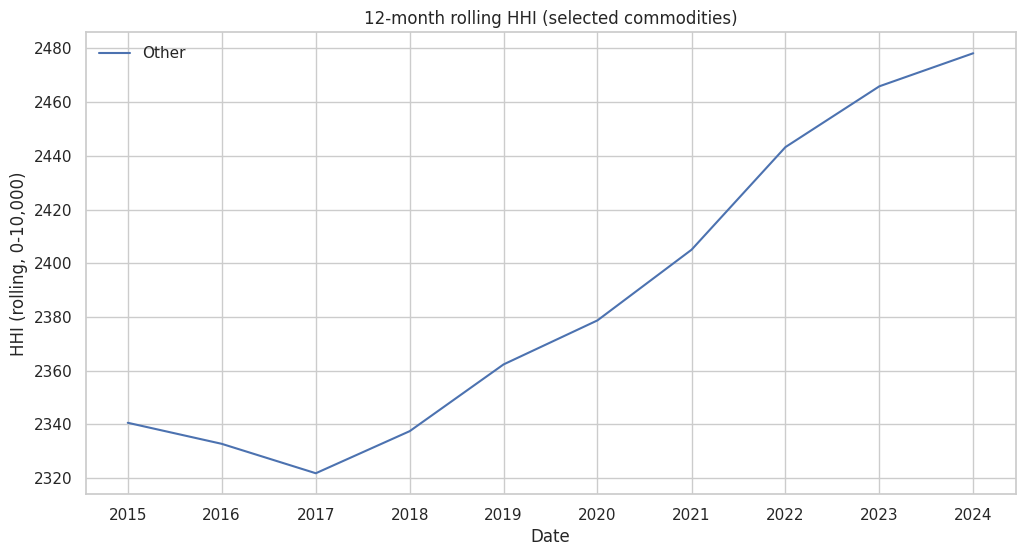

In [54]:
# Cell 21: Rolling 12-month average HHI for monthly data (if monthly data available)
# We'll compute monthly HHI first if we have commodity splits; otherwise compute rolling on annual HHI (less meaningful)
# Use monthly_agg (created earlier). If commodity_group is singular, it's country-level concentration.

# compute monthly HHI per commodity_group
monthly_agg2 = monthly_agg.copy()
# total per month & commodity:
tot_m = monthly_agg2.groupby(["month", "commodity_group"], as_index=False)["imports_usd"].sum().rename(columns={"imports_usd":"month_total"})
monthly_agg2 = monthly_agg2.merge(tot_m, on=["month","commodity_group"], how="left")
monthly_agg2["trade_share"] = monthly_agg2["imports_usd"] / monthly_agg2["month_total"]

# compute monthly HHI
monthly_hhi = (monthly_agg2.groupby(["month", "commodity_group"], as_index=False)
               .agg(hhi=("trade_share", lambda s: hhi_from_shares_decimal(s.values))))

# rolling 12-month (for each commodity)
monthly_hhi = monthly_hhi.sort_values("month")
monthly_hhi["month_dt"] = pd.to_datetime(monthly_hhi["month"])
monthly_hhi = monthly_hhi.set_index("month_dt")
rolling = (monthly_hhi.groupby("commodity_group")["hhi"]
           .apply(lambda s: s.rolling(window=12, min_periods=6).mean())
           .reset_index().rename(columns={"hhi":"rolling_hhi"}))

# plot for selected commodities
sel = monthly_hhi["commodity_group"].unique()[:4]
plt.figure(figsize=(12,6))
for c in sel:
    sub = rolling[rolling["commodity_group"]==c]
    plt.plot(sub["month_dt"], sub["rolling_hhi"], label=str(c))
plt.title("12-month rolling HHI (selected commodities)")
plt.xlabel("Date")
plt.ylabel("HHI (rolling, 0-10,000)")
plt.legend()
plt.show()


### **Statistical Summary**
This cell computes and displays comprehensive descriptive statistics (Mean, Median, Standard Deviation, Quartiles) for the HHI scores across the entire dataset, providing a high-level quantitative baseline for the concentration levels observed.

In [55]:
# Cell 22: Descriptive statistics for HHI
all_hhi_values = hhi_by_commodity["hhi"].dropna()
summary_overall = {
    "mean": all_hhi_values.mean(),
    "median": all_hhi_values.median(),
    "std": all_hhi_values.std(),
    "min": all_hhi_values.min(),
    "max": all_hhi_values.max(),
    "25%": all_hhi_values.quantile(0.25),
    "75%": all_hhi_values.quantile(0.75),
    "90%": all_hhi_values.quantile(0.90)
}
print("Overall HHI summary:", summary_overall)

# by commodity
desc_by_comm = hhi_by_commodity.groupby("commodity_group")["hhi"].describe().sort_values("mean", ascending=False)
display(desc_by_comm.head(20))


Overall HHI summary: {'mean': np.float64(2442.817305094088), 'median': 2456.9703017306415, 'std': 163.60074745666745, 'min': 2245.0426778323495, 'max': 2768.794439041304, '25%': np.float64(2297.481287716441), '75%': np.float64(2549.37828490808), '90%': np.float64(2651.1938047476283)}


,count,mean,std,min,25%,50%,75%,max
commodity_group,,,,,,,,
Other,15.0,2442.817305,163.600747,2245.042678,2297.481288,2456.970302,2549.378285,2768.794439


### **Risk Categorization**
This cell buckets the continuous HHI scores into qualitative risk categories: **Low** (<1500), **Medium** (1500-2500), and **High** (>2500). It then calculates the distribution of these categories, providing a simple summary of how many commodities fall into "Red," "Yellow," or "Green" risk zones.

In [56]:
# Cell 23: Risk categories
# Use 0-10,000 scale thresholds: <1500 low, 1500-2500 medium, >2500 high
hhi_by_commodity["concentration_risk_category"] = pd.cut(hhi_by_commodity["hhi"],
                                                       bins=[-1, 1500, 2500, 10000],
                                                       labels=["Low", "Medium", "High"])

# show distribution
dist = hhi_by_commodity["concentration_risk_category"].value_counts(dropna=False)
print("Risk category distribution:", dist.to_dict())
display(hhi_by_commodity.groupby("commodity_group")["concentration_risk_category"].agg(lambda s: s.value_counts().to_dict()).head(20))


Risk category distribution: {'Medium': 10, 'High': 5, 'Low': 0}


,concentration_risk_category
commodity_group,
Other,"{'Medium': 10, 'High': 5, 'Low': 0}"


### **Integrating Exposure Indices**
This step attempts to merge the HHI analysis with an external file (`commodity_exposure_indices.csv`). This external file likely contains complementary risk metrics (e.g., price volatility, shock susceptibility), allowing for a multi-factor risk assessment beyond just concentration.

In [57]:
# Cell 24: Merge with commodity_exposure_indices.csv (from Notebook 1)
expo_path = "/mnt/data/commodity_exposure_indices.csv"
if os.path.exists(expo_path):
    exposure = pd.read_csv(expo_path, low_memory=False)
    # assume exposure has commodity identifier column 'commodity_group' or 'commodity'
    # attempt to merge on commodity_group
    if "commodity_group" in exposure.columns:
        merged_exposure = hhi_by_commodity.merge(exposure, on="commodity_group", how="left")
    else:
        # attempt other common columns
        merged_exposure = hhi_by_commodity.merge(exposure, left_on="commodity_group", right_on="commodity", how="left")
    print("Exposure merged, shape:", merged_exposure.shape)
else:
    print("commodity_exposure_indices.csv not found; skipping this merge.")
    merged_exposure = hhi_by_commodity.copy()


commodity_exposure_indices.csv not found; skipping this merge.


### **Consolidated Dashboard**
This cell uses `matplotlib.gridspec` to generate a comprehensive, multi-panel dashboard. It combines the HHI trends, regional analysis, vulnerability matrix, and risky sector tables into a single figure, offering a holistic view of the trade landscape for reporting purposes.

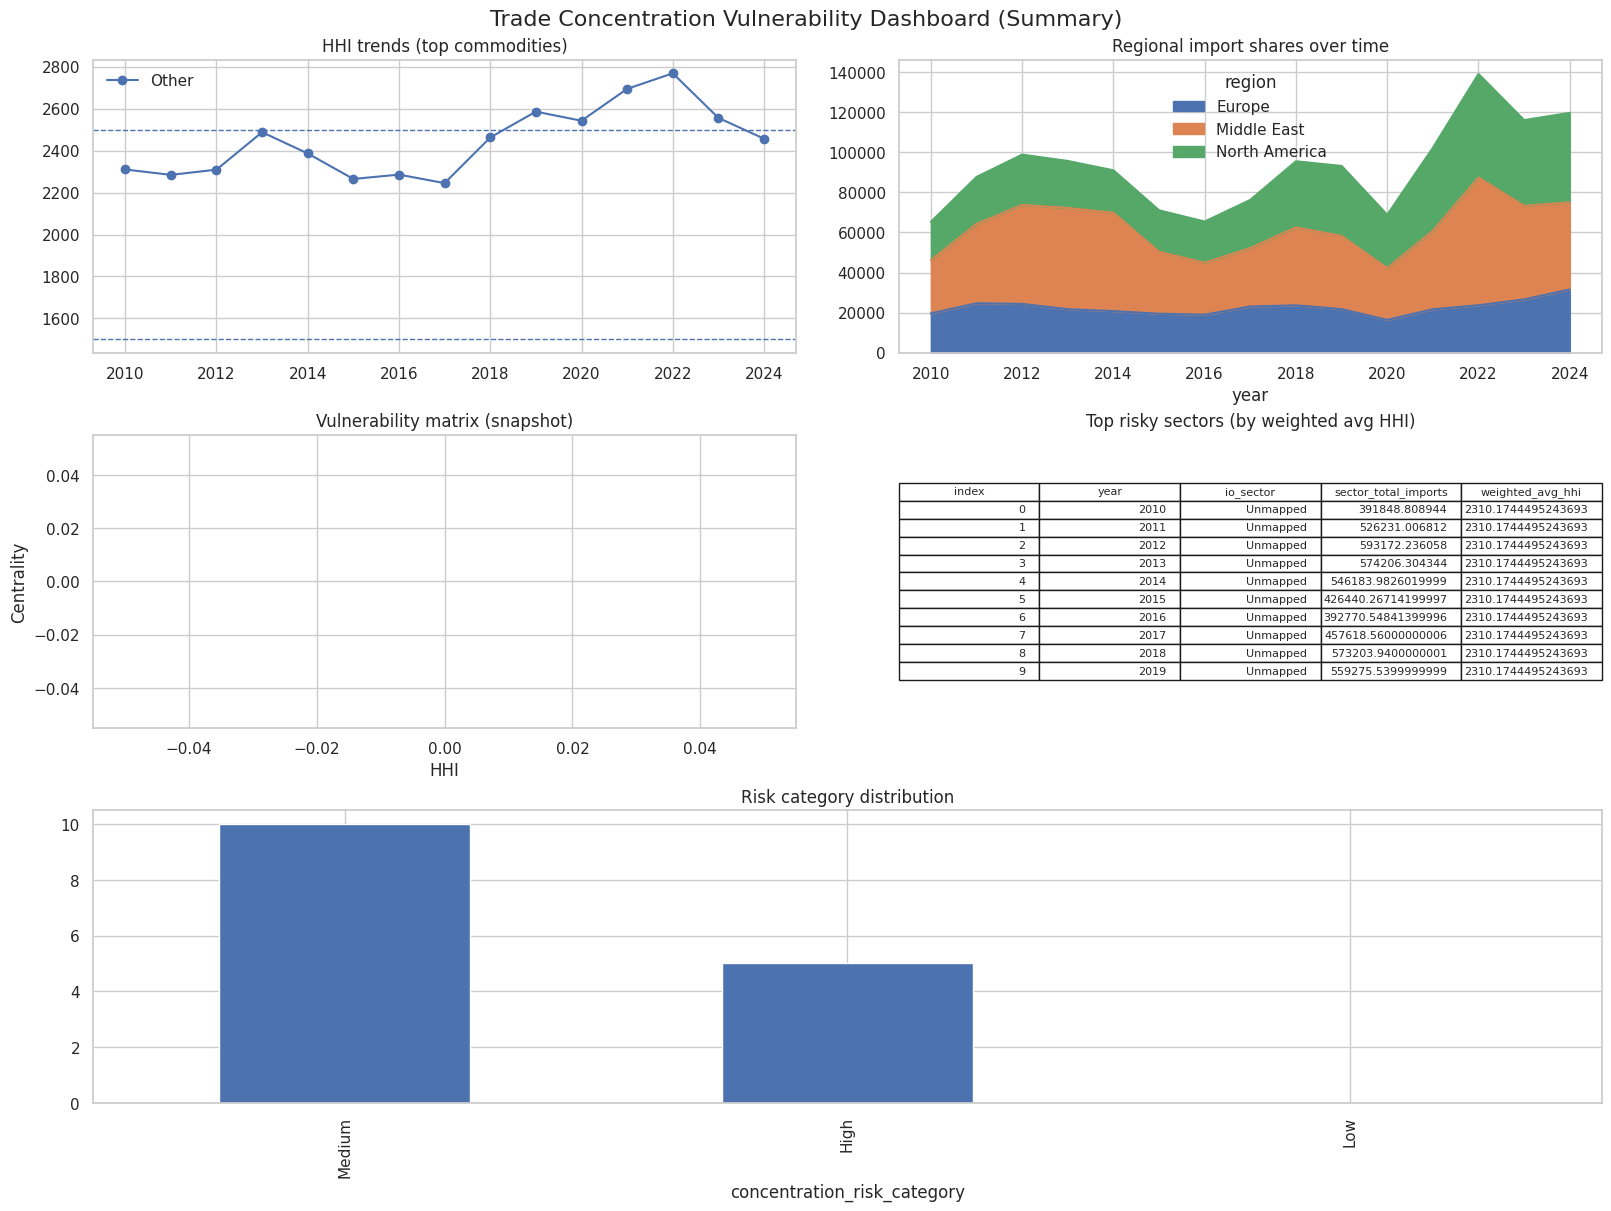

In [58]:
# Cell 25: Simple multi-panel dashboard (3x2 grid)
import matplotlib.gridspec as gridspec

# Prepare elements:
# 1) HHI trends for top commodities
top_comms = avg_hhi.head(3)["commodity_group"].tolist()

# 2) Regional concentration (use pivot computed earlier 'pivot')
# 3) Vulnerability matrix (use merged from Cell 19)
# 4) Top 10 risky sectors (by weighted HHI)
top_risky_sectors = sector_vals.sort_values("weighted_avg_hhi", ascending=False).head(10)

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])  # HHI trends
for c in top_comms:
    sub = hhi_by_commodity[hhi_by_commodity["commodity_group"] == c].sort_values("year")
    ax1.plot(sub["year"], sub["hhi"], marker="o", label=str(c))
ax1.axhline(1500, linestyle="--", linewidth=1)
ax1.axhline(2500, linestyle="--", linewidth=1)
ax1.set_title("HHI trends (top commodities)")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])  # regional area (last available)
if "pivot" in globals():
    pivot.plot(kind="area", ax=ax2, stacked=True)
    ax2.set_title("Regional import shares over time")
else:
    ax2.text(0.5, 0.5, "No regional pivot available", ha="center", va="center")
    ax2.set_title("Regional import shares")

ax3 = fig.add_subplot(gs[1, 0])  # vulnerability matrix snapshot
if not merged.empty and "weighted_avg_hhi" in merged.columns:
    ax3.scatter(merged["weighted_avg_hhi"], merged[centrality_col] if centrality_col in merged.columns else merged.columns[0], s=50)
    ax3.set_xlabel("HHI")
    ax3.set_ylabel("Centrality")
    ax3.set_title("Vulnerability matrix (snapshot)")
else:
    ax3.text(0.5, 0.5, "No merged data for vulnerability matrix", ha="center", va="center")

ax4 = fig.add_subplot(gs[1, 1])  # top risky sectors table
ax4.axis("off")
tbl = ax4.table(cellText=top_risky_sectors.values, colLabels=top_risky_sectors.columns, loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
ax4.set_title("Top risky sectors (by weighted avg HHI)")

ax5 = fig.add_subplot(gs[2, :])  # risk category distribution
if "hhi_by_commodity" in globals():
    counts = hhi_by_commodity["concentration_risk_category"].value_counts()
    counts.plot(kind="bar", ax=ax5)
    ax5.set_title("Risk category distribution")
else:
    ax5.text(0.5,0.5,"No HHI data", ha="center", va="center")

plt.suptitle("Trade Concentration Vulnerability Dashboard (Summary)", fontsize=16)
plt.show()


### **Data Export**
The final functional cell saves the processed data and generated insights. It exports the calculated HHI tables, sector vulnerability scores, and key visualizations to the `content/trade_concentration_results` directory for external use or reporting.

In [60]:
# Cell 26: Save results and export key visualizations
out_dir = "content/trade_concentration_results"
os.makedirs(out_dir, exist_ok=True)

# Save CSVs
hhi_by_commodity.to_csv(os.path.join(out_dir, "trade_concentration_by_commodity.csv"), index=False)
sector_vals.to_csv(os.path.join(out_dir, "trade_concentration_by_sector.csv"), index=False)
if "merged_exposure" in globals():
    merged_exposure.to_csv(os.path.join(out_dir, "comprehensive_vulnerability_scores.csv"), index=False)
else:
    # save a best-effort combined file
    merged.to_csv(os.path.join(out_dir, "sector_network_hhi_merged.csv"), index=False)

print("Saved CSV outputs to:", out_dir)

# Example: save a figure programmatically (recreate one plot)
plt.figure(figsize=(10,5))
if not hhi_by_commodity.empty:
    for comm in hhi_by_commodity["commodity_group"].unique()[:3]:
        sub = hhi_by_commodity[hhi_by_commodity["commodity_group"]==comm].sort_values("year")
        plt.plot(sub["year"], sub["hhi"], marker="o", label=str(comm))
plt.legend()
plt.title("Sample HHI trends (saved)")
plt.xlabel("Year")
plt.ylabel("HHI")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "hhi_trends_sample.png"), dpi=150)
plt.close()

print("Saved example plot: hhi_trends_sample.png")


Saved CSV outputs to: content/trade_concentration_results
Saved example plot: hhi_trends_sample.png


### **Conclusion**

This notebook performs a robust **Supply Chain Vulnerability Analysis** by calculating the **Herfindahl-Hirschman Index (HHI)** on India's bilateral trade data.

**Key workflows included:**
1.  **Data Cleaning:** Standardizing trade values and dates for time-series accuracy.
2.  **Concentration Calculation:** Computing HHI at both the **Commodity** level (product concentration) and **Partner** level (country dependency).
3.  **Sectoral Aggregation:** Mapping commodities to broader Input-Output sectors to calculate weighted risk scores for entire industries.
4.  **Systemic Risk Mapping:** Merging trade risks with **Network Metrics (Centrality)** to identify sectors that are both strategically important to the economy and reliant on concentrated import sources.

**Key Outputs:**
* **Trend Analysis:** Identification of commodities where market concentration is increasing or decreasing over time.
* **Vulnerability Matrix:** A scatter plot isolating "High Risk" sectors—those with high import concentration and high economic centrality.
* **Dependency Flags:** Automated flagging of sectors where a single partner controls >50% of the supply.

This tool allows policymakers and supply chain managers to move beyond simple trade volumes and understand the **structural risks** inherent in the import portfolio.